In [15]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
from scipy.signal import argrelextrema
import os

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

dataRepo = os.getcwd() + "/Figure1_Data/"

# Figure 1A
Cartoon created in Illustrator

# Figure 1B

In [16]:
##nuc score files
orig_2015_nucEnr = pd.read_csv(dataRepo + '20150914_orig_nuc.csv', header=None)
nls11_yelans_nucEnr = pd.read_csv(dataRepo + '20150914_nls11_nuc.csv', header=None)

##timepoint files -- this corresponds to the timepoint that a given nuclearEnrichment score was seen
orig_2015_timepts = pd.read_csv(dataRepo + '20150914timepts_orig.csv')
nls11_yelans_timepts = pd.read_csv(dataRepo + '20150914timepts_nls11.csv')

In [17]:
def selectTrackedCells(nucEnrDF, timeptsDF, numFrames, indexFrom=1, maxUntrackedFrames=3):
    #find cells which pass some cutoff (i.e numFrames - maxUntrackedFrames) for the number of frames that they are tracked
    frameNumList = np.linspace(indexFrom, numFrames, num=numFrames)
    passUntrackedCutoff = timeptsDF.apply(lambda x: len(set(frameNumList).intersection(x.tolist())) > 
                                          (numFrames-maxUntrackedFrames), axis=1)
    return [nucEnrDF.loc[passUntrackedCutoff, :], timeptsDF.loc[passUntrackedCutoff, :]]

def organizeTrackedCells(nucEnrDF, timeptsDF, numFrames, nanVal=np.nan):
    #convert matlab timepoints format to a normal dataframe with nanVal for missing values
    trackedCellSeriesList = []
    for rowInd in range(timeptsDF.shape[0]):
        locArray = np.full(numFrames, nanVal)
        trackedTimepts = sum(~np.isnan(timeptsDF.iloc[rowInd, :]))
        for timeptInd in range(trackedTimepts):
            #matlab indexes from 1
            timept = int(timeptsDF.iloc[rowInd, timeptInd])-1
            if timept < numFrames:
                locArray[timept] = nucEnrDF.iloc[rowInd, timeptInd]
        trackedCellSeriesList.append(pd.Series(locArray.copy()))
    trackedCellDF = pd.concat(trackedCellSeriesList, axis=1)
    return trackedCellDF

def normNucEnrich(nucEnrDF):
    #divide by the first index to normalize nuclear enrichment to 1 at t=0
    normNCEnrich = nucEnrDF.apply(lambda x: x/nucEnrDF.iloc[0,:], axis=1)
    return normNCEnrich

In [18]:
#two pulses of light are delivered in the experiment, but figure 1b focuses only on the first pulse 
#create df with only the first 17 images, which are the first ~8 minutes of the experiment
orig_2015_nucEnr_onePulse = orig_2015_nucEnr.iloc[:, 0:17]
nls11_yelans_nucEnr_onePulse = nls11_yelans_nucEnr.iloc[:, 0:17]
orig_2015_timepts_onePulse = orig_2015_timepts.iloc[:, 0:17]
nls11_yelans_timepts_onePulse = nls11_yelans_timepts.iloc[:, 0:17]

In [19]:
#find cells which meet the tracking cutoff (here 30 frames, so any tracked cell) for the whole experiment and the one pulse data
trackedCells_nucEnr_orig_2015, trackedCells_timepts_orig_2015 = selectTrackedCells(orig_2015_nucEnr, orig_2015_timepts, 30)
trackedCells_nucEnr_nls11_yelans, trackedCells_timepts_nls11_yelans = selectTrackedCells(nls11_yelans_nucEnr, 
                                                                                         nls11_yelans_timepts, 30)

trackedCells_nucEnr_orig_2015_op, trackedCells_timepts_orig_2015_op = selectTrackedCells(orig_2015_nucEnr_onePulse, 
                                                                                         orig_2015_timepts_onePulse, 17)
trackedCells_nucEnr_nls11_yelans_op, trackedCells_timepts_nls11_yelans_op = selectTrackedCells(nls11_yelans_nucEnr_onePulse, 
                                                                                               nls11_yelans_timepts_onePulse, 17)

In [20]:
#organize the dataframes so that they can be plotted as a timecourse
orgNucEnr_orig_2015 = organizeTrackedCells(trackedCells_nucEnr_orig_2015, trackedCells_timepts_orig_2015, 30)
orgNucEnr_nls11_yelans = organizeTrackedCells(trackedCells_nucEnr_nls11_yelans, trackedCells_timepts_nls11_yelans, 30)
orgNucEnr_orig_2015_op = organizeTrackedCells(trackedCells_nucEnr_orig_2015_op, trackedCells_timepts_orig_2015_op, 17)
orgNucEnr_nls11_yelans_op = organizeTrackedCells(trackedCells_nucEnr_nls11_yelans_op, trackedCells_timepts_nls11_yelans_op, 17)

In [21]:
#normalize the nuclear enrichment for the organized dataframes
orgNucEnr_orig_2015_norm = normNucEnrich(orgNucEnr_orig_2015)
orgNucEnr_nls11_yelans_norm = normNucEnrich(orgNucEnr_nls11_yelans)
orgNucEnr_orig_2015_norm_op = normNucEnrich(orgNucEnr_orig_2015_op)
orgNucEnr_nls11_yelans_norm_op = normNucEnrich(orgNucEnr_nls11_yelans_op)

In [22]:
def tsplot(ax, data, time_start=None, time_end=None, **kw):
    #plot the mean of a timeseries trace
    if time_start is None or time_end is None:
        x = np.arange(data.shape[0])
    else:
        x=np.arange(start=time_start, stop=time_end, step=(time_end-time_start)/(data.shape[0]*1.0))
    est = np.nanmean(data, axis=1)
    sd = np.nanstd(data, axis=1)
    cis = (est - sd, est + sd)
    print cis
    print cis[0].dtype
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

In [23]:
def tsplot_median(ax, data, time_start=None, time_end=None, **kw):
    #plot the median of a timeseries trace
    if time_start is None or time_end is None:
        x = np.arange(data.shape[0])
    else:
        x=np.arange(start=time_start, stop=time_end, step=(time_end-time_start)/(data.shape[0]*1.0))
    est = np.nanmedian(data, axis=1)
    sd = np.nanstd(data, axis=1)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

(array([ 1.        ,  0.93956429,  0.93371585,  0.92144554,  0.91102158,
        0.91708868,  0.91385328,  0.92187222,  0.94857991,  0.95780396,
        0.94111685,  0.95364137,  0.90444467,  0.94236594,  0.93456215,
        0.90183667,  0.92578505]), array([ 1.        ,  1.07453754,  1.0857701 ,  1.06900098,  1.06204201,
        1.06324007,  1.0690895 ,  1.0984803 ,  1.0910247 ,  1.11162753,
        1.10293786,  1.11188715,  1.11748228,  1.07920769,  1.05996345,
        1.06322231,  1.05412947]))
float64
(array([ 1.        ,  0.94611851,  0.94126489,  0.94304958,  0.94162234,
        0.92792592,  0.93276675,  1.06563241,  1.11367842,  1.10222195,
        1.10280927,  1.1018875 ,  1.09908467,  1.06246764,  1.00105635,
        0.96358673,  0.93559834]), array([ 1.        ,  1.04546136,  1.04701671,  1.04771245,  1.05070366,
        1.04865422,  1.04568732,  1.34345376,  1.44821392,  1.4235241 ,
        1.44051382,  1.42101828,  1.39683611,  1.32707448,  1.17116296,
        1.07866287,  

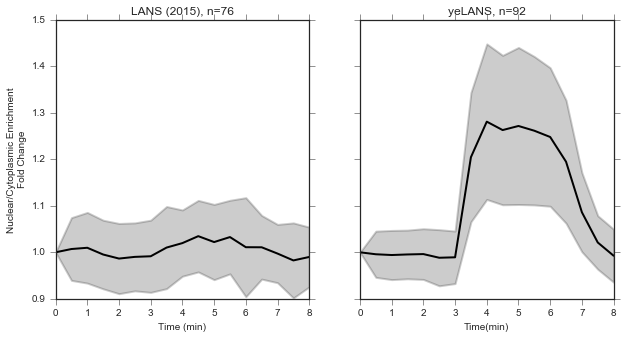

In [24]:
#plot the nuclear/cytoplasmic localization for LANS and yeLANS
fig, (ax,ax1) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
tsplot(ax, orgNucEnr_orig_2015_norm_op, time_start=0., time_end=8.5, color="black", linewidth=2)
tsplot(ax1, orgNucEnr_nls11_yelans_norm_op, time_start=0., time_end=8.5, color="black", linewidth=2)
ax.set_title('LANS (2015), n='+str(orgNucEnr_orig_2015_norm_op.shape[1]))
ax1.set_title('yeLANS, n='+str(orgNucEnr_nls11_yelans_norm_op.shape[1]))
ax.set_ylabel("Nuclear/Cytoplasmic Enrichment\nFold Change")
ax.set_xlabel("Time (min)")
ax1.set_xlabel("Time(min)")
figure = "Figure1B_"
date = "20150914"
dest = figure + date + '_localization_normSD_mean_onePulse'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

In [25]:
#read in the growth data from CSV files
growthData1 =  pd.read_csv(dataRepo + 'LO20180414_OD600_kinetic_20180725.csv')
plateMap1 =  pd.read_csv(dataRepo + '20180725_PlateMap_LOVTrap_GrowthComp.csv')
growthData2 =  pd.read_csv(dataRepo + 'LO20180414_OD600_kinetic_20180727.csv')
plateMap2 =  pd.read_csv(dataRepo + '20180727_PlateMap_LOVTrap_GrowthComp.csv')
growthData3 =  pd.read_csv(dataRepo + 'LO20180414_OD600_kinetic_20180809.csv')
plateMap3 =  pd.read_csv(dataRepo + '20180809_PlateMap_LOVTrap_GrowthComp.csv')
rows = ['A','B','C','D','E','F','G','H']
cols = ['1','2','3','4','5','6','7','8','9','10','11','12']

In [26]:
def plateMapParse(PMdf):
    #convert dataframe read from csv into dictionary for mapping strains to locations
    locationDict = {}
    for dfRowInd in range(len(PMdf)):
        if PMdf['Strain'][dfRowInd] == 'empty':
            continue
        else:
            #print dfRowInd
            location = rows[PMdf['Row'][dfRowInd]-1] + cols[PMdf['Col'][dfRowInd]-1]
            locationDict[location] = PMdf['Strain'][dfRowInd]
    return locationDict.copy()

def getStrainLocations(locDict, strainNum):
    #find a given strainNum location in a dictionary (does not assume that strainNum appears only once)
    locDictKeys = locDict.keys()
    strainLocs = []
    for dictKey in locDictKeys:
        if locDict[dictKey] == strainNum:
            strainLocs += [dictKey]
    return strainLocs

def collapseReplicates(GCdf, locDict, numDataPoints, norm=1, blank=0):
    #technical replicates are denoted with the exact same name -- collapse these using the mean
    #if norm, subtract the value for blank wells
    strainList = np.unique(locDict.values())
    collapsedGCdf = pd.DataFrame(index = strainList, columns=range(numDataPoints))
    for strNumInd in range(len(strainList)):
        strNum = strainList[strNumInd]
        strLocs = getStrainLocations(locDict, strNum)
        strGCdf = GCdf[strLocs]
        strCollapsedGCdf = strGCdf.mean(axis=1)
        collapsedGCdf.loc[strNum] = strCollapsedGCdf
    if norm:
        collapsedGCdf -=collapsedGCdf.loc[blank]
    return collapsedGCdf

def collapseBioReplicates(longGrowthReadingsDF, numTimepoints, strainNameStr='StrainID', readingStr='value', 
                          timeStr='variable', hourStr='Timepoint'):
    #for a df, collapse replicates that have the exact same strain ID (strain ID of x.1 should be x)
    #used here to collapse biological replicates taken across 3 days
    strainNames = np.unique(longGrowthReadingsDF[strainNameStr])
    strainSummaryList = []
    for strainStr in strainNames:
        strainNameList = pd.Series([strainStr]*numTimepoints)
        strainReadingsDF=longGrowthReadingsDF[longGrowthReadingsDF[strainNameStr]==strainStr].groupby(timeStr)
        strainSummaryDF = pd.concat([strainNameList, strainReadingsDF.apply(np.mean)[readingStr], 
                                     strainReadingsDF.apply(np.std)[readingStr], 
                                     strainReadingsDF.apply(np.mean)[hourStr]], axis=1).reset_index(drop=True)
        strainSummaryDF.columns = ['StrainName', 'Mean', 'Std', 'Timepoint']
        strainSummaryList.append(strainSummaryDF.copy())
    allStrainSummaryDF = pd.concat(strainSummaryList)
    return allStrainSummaryDF


In [27]:
#parse the platemaps which show the location of each strain and replicate
strLocDict1 = plateMapParse(plateMap1)
strLocDict2 = plateMapParse(plateMap2)
strLocDict3 = plateMapParse(plateMap3)
#collapse strain replicates for growth expt 1
growthDF1 = collapseReplicates(growthData1, strLocDict1,48, norm=0, blank=1)
normGrowthDF1 = collapseReplicates(growthData1, strLocDict1, 48, blank=1)
strainNums1 = list(normGrowthDF1.index)
normGrowthDFLabels1 =normGrowthDF1.copy()
normGrowthDFLabels1['Strain'] = strainNums1

#do the same for other 2 growth experiments
growthDF2 = collapseReplicates(growthData2, strLocDict2,48, norm=0, blank=1)
normGrowthDF2 = collapseReplicates(growthData2, strLocDict2, 48, blank=1)
strainNums2 = list(normGrowthDF2.index)
normGrowthDFLabels2 =normGrowthDF2.copy()
normGrowthDFLabels2['Strain'] = strainNums2

growthDF3 = collapseReplicates(growthData3, strLocDict3,48, norm=0, blank=0)
normGrowthDF3 = collapseReplicates(growthData3, strLocDict3, 48, blank=0)
strainNums3 = list(normGrowthDF3.index)
normGrowthDFLabels3 =normGrowthDF3.copy()
normGrowthDFLabels3['Strain'] = strainNums3

In [28]:
#convert data from wide to long for plotting
longNormGrowthDF1 = pd.melt(normGrowthDFLabels1, id_vars=['Strain'], value_vars = range(0,48))
longNormGrowthDF2 = pd.melt(normGrowthDFLabels2, id_vars=['Strain'], value_vars = range(0,48))
longNormGrowthDF3 = pd.melt(normGrowthDFLabels3, id_vars=['Strain'], value_vars = range(0,48))
longNormGrowthDFAll = pd.concat([longNormGrowthDF1, longNormGrowthDF2, longNormGrowthDF3])

longNormGrowthDFAll['StrainID'] = longNormGrowthDFAll['Strain'].apply(math.floor)
longNormGrowthDFAll['Timepoint'] = longNormGrowthDFAll['variable']/3.0

longNormGrowthAll_cbr = collapseBioReplicates(longNormGrowthDFAll, 48)

In [29]:
def tsplot_tecan(ax, data, meanStr, stdStr, timepointStr, **kw):
    #plot timeseries using tecan/growth data
    x = data[timepointStr]
    est = data[meanStr]
    sd = data[stdStr]
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.05, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

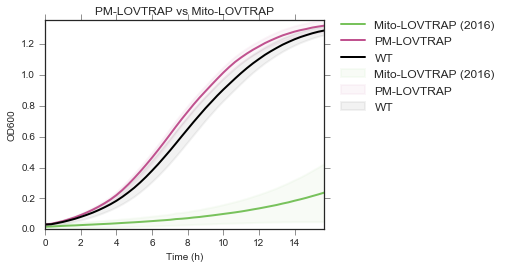

In [30]:
fig, ax = plt.subplots(nrows=1, sharey=True, figsize=(5, 3.75))
#485 corresponds to pLO485 -- TDH3-iRFP-Mito-LOVTRAP transformed into WCD 230, which is yLO240
#488 corresponds to pLO488 -- TDH3-iRFP-PM-LOVTRAP transformed into WCD 230, which is yLO243
#230 corresponds to yWCD230
tsplot_tecan(ax, longNormGrowthAll_cbr[longNormGrowthAll_cbr['StrainName']==485.0], 'Mean', 'Std', 'Timepoint', 
             color = "#78c25c", linewidth=2, label='Mito-LOVTRAP (2016)')
tsplot_tecan(ax, longNormGrowthAll_cbr[longNormGrowthAll_cbr['StrainName']==488.0], 'Mean', 'Std', 'Timepoint', 
             color = "#c0528f", linewidth=2, label='PM-LOVTRAP')
tsplot_tecan(ax, longNormGrowthAll_cbr[longNormGrowthAll_cbr['StrainName']==230.0], 'Mean', 'Std', 'Timepoint', 
             color = 'black', linewidth=2, label='WT')
ax.legend(bbox_to_anchor=(1.65, 1.05))
ax.set_title('PM-LOVTRAP vs Mito-LOVTRAP')
ax.set_xlabel("Time (h)")
ax.set_ylabel("OD600")
figure = "Figure1B_"
date = "20180725_27_0809"
dest = figure + date + '_meanLocalization_SD_TDH3'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

# Figure 1C

In [31]:
#80m inputs were given to p3 for the 20180321 experiment and to p4 for the 20180327 experiment
#read in the nuclear intensity csv files
d_21_p3_80m_nuc = pd.read_csv(dataRepo + '20180324_p3CTSeed_nuc.csv', header=None)
p4_80m_nuc = pd.read_csv(dataRepo + '20180402_p4CTSeed_nuc.csv', header=None)

#read in the cytoplasmic intensity
d_21_p3_80m_cyt = pd.read_csv(dataRepo + '20180324_p3CTSeed_cyt.csv', header=None)
p4_80m_cyt = pd.read_csv(dataRepo + '20180402_p4CTSeed_cyt.csv', header=None)

#read in the background intensity
d_21_p3_80m_bkg = pd.read_csv(dataRepo + '20180324_p3CTSeed_bkg.csv', header=None)
p4_80m_bkg = pd.read_csv(dataRepo + '20180402_p4CTSeed_bkg.csv', header=None)

In [32]:
#adjust DF of brightness by background
def bkgAdj(brightDF, bkgVec):
    brightAdj = brightDF.apply(lambda x: x-bkgVec.iloc[0,:], 0)
    return brightAdj
#calculate nuclear/cytoplasmic enrichment and normalize
def nucEnrich(nucDF, cytoDF):
    nucCytoEnrich = nucDF/cytoDF
    normNCEnrich = nucCytoEnrich.apply(lambda x: x/nucCytoEnrich.iloc[0,:], 1)
    return [nucCytoEnrich, normNCEnrich]

In [33]:
#adjust intensity of nucleus and cytoplasm using the background intensity
d_21_p3_80m_nucAdj = bkgAdj(d_21_p3_80m_nuc, d_21_p3_80m_bkg)
p4_80m_nucAdj = bkgAdj(p4_80m_nuc, p4_80m_bkg)

d_21_p3_80m_cytAdj = bkgAdj(d_21_p3_80m_cyt, d_21_p3_80m_bkg)
p4_80m_cytAdj = bkgAdj(p4_80m_cyt, p4_80m_bkg)


In [34]:
def rmUntrackedCells(nucDF, cytDF, maxUntrackedFrames):
    #untracked cells often have 0 or negative reading (can be used for bkg-adj cells or not adjusted)
    pass0Cutoff_nucDF = nucDF.apply(lambda x: sum(x<=0) > maxUntrackedFrames, 0)
    pass0Cutoff_cytDF = cytDF.apply(lambda x: sum(x<=0) > maxUntrackedFrames, 0)
    nucDF_woOutliers = nucDF.drop(list(np.where(pass0Cutoff_nucDF)[0]), axis=1)
    cytDF_woOutliers =cytDF.drop(list(np.where(pass0Cutoff_nucDF)[0]), axis=1)
    return [nucDF_woOutliers, cytDF_woOutliers]

def rmOutliers(normNCDF, maxNegFrames): 
    #add in removal of cells which have negative values at any point
    passNegCutoffDF = normNCDF.apply(lambda x: sum(x<0) > maxNegFrames, 0)
    normNCDFwoOutliers = normNCDF.drop(list(np.where(passNegCutoffDF)[0]), axis=1)
    return normNCDFwoOutliers

In [35]:
#remove untracked cells
d_21_p3_80m_nucAdj_rm_UT, d_21_p3_80m_cytAdj_rm_UT = rmUntrackedCells(d_21_p3_80m_nucAdj, d_21_p3_80m_cytAdj, 3)
p4_80m_nucAdj_rm_UT, p4_80m_cytAdj_rm_UT = rmUntrackedCells(p4_80m_nucAdj, p4_80m_cytAdj, 3)

#normalize to nuclear enrichment at t0
d_21_p3_80m_nucCytoEnr_rm_UT, d_21_p3_80m_normNucCytoEnr_rm_UT = nucEnrich(d_21_p3_80m_nucAdj_rm_UT, d_21_p3_80m_cytAdj_rm_UT)
p4_80m_nucCytoEnr_rm_UT, p4_80m_normNucCytoEnr_rm_UT = nucEnrich(p4_80m_nucAdj_rm_UT, p4_80m_cytAdj_rm_UT)

#remove outliers as well
d_21_p3_80m_normNucCytoEnr_rm2 = rmOutliers(d_21_p3_80m_normNucCytoEnr_rm_UT, 0)
p4_80m_normNucCytoEnr_rm2 = rmOutliers(p4_80m_normNucCytoEnr_rm_UT, 0)


In [36]:
#concatenate traces for both positions together
input80_normNucCytoEnr_rm2 = pd.concat([d_21_p3_80m_normNucCytoEnr_rm2, p4_80m_normNucCytoEnr_rm2], axis=1, ignore_index=True)

(array([ 1.        ,  0.97442705,  0.97086544,  1.06516071,  1.06714559,
        1.07167533,  1.09247932,  1.08894451,  1.09647827,  1.08314214,
        1.10430158,  1.1039731 ,  1.11803542,  1.1178552 ,  1.13434166,
        1.11845796,  1.13508407,  1.14244323,  1.14441291,  1.13868417,
        1.14025457,  1.15528536,  1.14057125,  1.14599759,  1.15846139,
        1.17182024,  1.14767249,  1.15688089,  1.16655675,  1.17691252,
        1.17326128,  1.17923311,  1.18045249,  1.17366884,  1.16930231,
        1.17434654,  1.17282493,  1.17451788,  1.17510948,  1.17775379,
        1.16305931,  1.17764168,  1.15679789,  1.15171762,  1.16473854,
        1.16197886,  1.16287405,  1.18258441,  1.16943408,  1.17081929,
        1.17211951,  1.18130446,  1.16516886,  1.17357353,  1.15210345,
        1.16987949,  1.17100243,  1.16265696,  1.17848808,  1.17914173,
        1.17394987,  1.16894784,  1.17201619,  1.13966727,  1.14287317,
        1.15111344,  1.15582735,  1.15493592,  1.15017803,  1.1

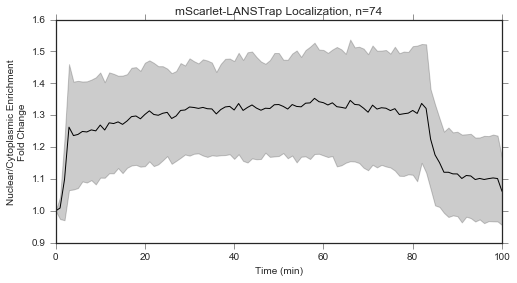

In [37]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(8, 4))
tsplot(ax, input80_normNucCytoEnr_rm2.iloc[0:101, :], color = "black")
ax.set_title('mScarlet-LANSTrap Localization, n='+str(input80_normNucCytoEnr_rm2.shape[1]))
ax.set_ylabel("Nuclear/Cytoplasmic Enrichment\nFold Change")
ax.set_xlabel("Time (min)")
figure = "Figure1C_"
date = "20180321_27"
dest = figure + date + '_localization_tsPlot_80_mean'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

# Figure 1D

In [38]:
##read in nuclear intensity files
d_21_p1_nuc, d_21_p2_nuc, d_21_p3_nuc, d_21_p4_nuc = [pd.read_csv(x, header=None) for x in 
                                                      glob.glob(dataRepo+"20180324_*_nuc.csv")]
p1_nuc, p2_nuc, p3_nuc, p4_nuc, p5_nuc, p6_nuc, p7_nuc, p8_nuc =[pd.read_csv(x, header=None) for x in 
                                                                 glob.glob(dataRepo+"20180402_*_nuc.csv")]

##read in cytoplasmic intensity files
d_21_p1_cyt, d_21_p2_cyt, d_21_p3_cyt, d_21_p4_cyt = [pd.read_csv(x, header=None) for x in 
                                                      glob.glob(dataRepo+"20180324_*_cyt.csv")]
p1_cyt, p2_cyt, p3_cyt, p4_cyt, p5_cyt, p6_cyt, p7_cyt, p8_cyt =[pd.read_csv(x, header=None) for x in 
                                                                 glob.glob(dataRepo+"20180402_*_cyt.csv")]

##read in background intensity files
d_21_p1_bkg, d_21_p2_bkg, d_21_p3_bkg, d_21_p4_bkg = [pd.read_csv(x, header=None) for x in 
                                                      glob.glob(dataRepo+"20180324_*_bkg.csv")]
p1_bkg, p2_bkg, p3_bkg, p4_bkg, p5_bkg, p6_bkg, p7_bkg, p8_bkg =[pd.read_csv(x, header=None) for x in 
                                                                 glob.glob(dataRepo+"20180402_*_bkg.csv")]

In [39]:
#assemble dataframes into lists for list comprehension
d_21_nuc_list = [d_21_p1_nuc, d_21_p2_nuc, d_21_p3_nuc, d_21_p4_nuc]
d_21_cyt_list = [d_21_p1_cyt, d_21_p2_cyt, d_21_p3_cyt, d_21_p4_cyt]
d_21_bkg_list = [d_21_p1_bkg, d_21_p2_bkg, d_21_p3_bkg, d_21_p4_bkg]
#subtract background intensity from nuclear and cytoplasmic intensity
d_21_p1_nucAdj, d_21_p2_nucAdj, d_21_p3_nucAdj, d_21_p4_nucAdj = [bkgAdj(d_21_nuc_list[i], d_21_bkg_list[i]) for i in 
                                                                  range(len(d_21_bkg_list))]
d_21_p1_cytAdj, d_21_p2_cytAdj, d_21_p3_cytAdj, d_21_p4_cytAdj = [bkgAdj(d_21_cyt_list[i], d_21_bkg_list[i]) for i in 
                                                                  range(len(d_21_bkg_list))]

In [40]:
#assemble dataframes into lists for list comprehension
p_nuc_list = [p1_nuc, p2_nuc, p3_nuc, p4_nuc, p5_nuc, p6_nuc, p7_nuc, p8_nuc]
p_cyt_list = [p1_cyt, p2_cyt, p3_cyt, p4_cyt, p5_cyt, p6_cyt, p7_cyt, p8_cyt]
p_bkg_list = [p1_bkg, p2_bkg, p3_bkg, p4_bkg, p5_bkg, p6_bkg, p7_bkg, p8_bkg]
#subtract background intensity from nuclear and cytoplasmic intensity
p1_nucAdj, p2_nucAdj, p3_nucAdj, p4_nucAdj, p5_nucAdj, p6_nucAdj, p7_nucAdj, p8_nucAdj = [bkgAdj(p_nuc_list[i], 
                                                                        p_bkg_list[i]) for i in range(len(p_bkg_list))]
p1_cytAdj, p2_cytAdj, p3_cytAdj, p4_cytAdj, p5_cytAdj, p6_cytAdj, p7_cytAdj, p8_cytAdj = [bkgAdj(p_cyt_list[i], 
                                                                        p_bkg_list[i]) for i in range(len(p_bkg_list))]

In [41]:
#remove untracked cells
d_21_p1_nucAdj_rm_UT, d_21_p1_cytAdj_rm_UT = rmUntrackedCells(d_21_p1_nucAdj, d_21_p1_cytAdj, 3)
d_21_p2_nucAdj_rm_UT, d_21_p2_cytAdj_rm_UT = rmUntrackedCells(d_21_p2_nucAdj, d_21_p2_cytAdj, 3)
d_21_p3_nucAdj_rm_UT, d_21_p3_cytAdj_rm_UT = rmUntrackedCells(d_21_p3_nucAdj, d_21_p3_cytAdj, 3)
d_21_p4_nucAdj_rm_UT, d_21_p4_cytAdj_rm_UT = rmUntrackedCells(d_21_p4_nucAdj, d_21_p4_cytAdj, 3)

p1_nucAdj_rm_UT, p1_cytAdj_rm_UT = rmUntrackedCells(p1_nucAdj, p1_cytAdj, 3)
p2_nucAdj_rm_UT, p2_cytAdj_rm_UT = rmUntrackedCells(p2_nucAdj, p2_cytAdj, 3)
p3_nucAdj_rm_UT, p3_cytAdj_rm_UT = rmUntrackedCells(p3_nucAdj, p3_cytAdj, 3)
p4_nucAdj_rm_UT, p4_cytAdj_rm_UT = rmUntrackedCells(p4_nucAdj, p4_cytAdj, 3)
p5_nucAdj_rm_UT, p5_cytAdj_rm_UT = rmUntrackedCells(p5_nucAdj, p5_cytAdj, 3)
p6_nucAdj_rm_UT, p6_cytAdj_rm_UT = rmUntrackedCells(p6_nucAdj, p6_cytAdj, 3)
p7_nucAdj_rm_UT, p7_cytAdj_rm_UT = rmUntrackedCells(p7_nucAdj, p7_cytAdj, 3)
p8_nucAdj_rm_UT, p8_cytAdj_rm_UT = rmUntrackedCells(p8_nucAdj, p8_cytAdj, 3)

In [42]:
#calculate nuclear enrichment
d_21_p1_nucCytoEnr_rm_UT, d_21_p1_normNucCytoEnr_rm_UT = nucEnrich(d_21_p1_nucAdj_rm_UT, d_21_p1_cytAdj_rm_UT)
d_21_p2_nucCytoEnr_rm_UT, d_21_p2_normNucCytoEnr_rm_UT = nucEnrich(d_21_p2_nucAdj_rm_UT, d_21_p2_cytAdj_rm_UT)
d_21_p3_nucCytoEnr_rm_UT, d_21_p3_normNucCytoEnr_rm_UT = nucEnrich(d_21_p3_nucAdj_rm_UT, d_21_p3_cytAdj_rm_UT)
d_21_p4_nucCytoEnr_rm_UT, d_21_p4_normNucCytoEnr_rm_UT = nucEnrich(d_21_p4_nucAdj_rm_UT, d_21_p4_cytAdj_rm_UT)

p1_nucCytoEnr_rm_UT, p1_normNucCytoEnr_rm_UT = nucEnrich(p1_nucAdj_rm_UT, p1_cytAdj_rm_UT)
p2_nucCytoEnr_rm_UT, p2_normNucCytoEnr_rm_UT = nucEnrich(p2_nucAdj_rm_UT, p2_cytAdj_rm_UT)
p3_nucCytoEnr_rm_UT, p3_normNucCytoEnr_rm_UT = nucEnrich(p3_nucAdj_rm_UT, p3_cytAdj_rm_UT)
p4_nucCytoEnr_rm_UT, p4_normNucCytoEnr_rm_UT = nucEnrich(p4_nucAdj_rm_UT, p4_cytAdj_rm_UT)
p5_nucCytoEnr_rm_UT, p5_normNucCytoEnr_rm_UT = nucEnrich(p5_nucAdj_rm_UT, p5_cytAdj_rm_UT)
p6_nucCytoEnr_rm_UT, p6_normNucCytoEnr_rm_UT = nucEnrich(p6_nucAdj_rm_UT, p6_cytAdj_rm_UT)
p7_nucCytoEnr_rm_UT, p7_normNucCytoEnr_rm_UT = nucEnrich(p7_nucAdj_rm_UT, p7_cytAdj_rm_UT)
p8_nucCytoEnr_rm_UT, p8_normNucCytoEnr_rm_UT = nucEnrich(p8_nucAdj_rm_UT, p8_cytAdj_rm_UT)

In [43]:
#remove negative cells
d_21_p1_normNucCytoEnr_rm2, d_21_p2_normNucCytoEnr_rm2, d_21_p3_normNucCytoEnr_rm2, d_21_p4_normNucCytoEnr_rm2 = [rmOutliers(rm_UT_df, 0) 
                                                    for rm_UT_df in [d_21_p1_normNucCytoEnr_rm_UT, d_21_p2_normNucCytoEnr_rm_UT,
                                                                    d_21_p3_normNucCytoEnr_rm_UT, d_21_p4_normNucCytoEnr_rm_UT]]

p1_normNucCytoEnr_rm2, p2_normNucCytoEnr_rm2, p3_normNucCytoEnr_rm2, p4_normNucCytoEnr_rm2 = [rmOutliers(rm_UT_df, 0) 
                                                    for rm_UT_df in [p1_normNucCytoEnr_rm_UT, p2_normNucCytoEnr_rm_UT,
                                                                    p3_normNucCytoEnr_rm_UT, p4_normNucCytoEnr_rm_UT]]
p5_normNucCytoEnr_rm2, p6_normNucCytoEnr_rm2, p7_normNucCytoEnr_rm2, p8_normNucCytoEnr_rm2 = [rmOutliers(rm_UT_df, 0) 
                                                    for rm_UT_df in [p5_normNucCytoEnr_rm_UT, p6_normNucCytoEnr_rm_UT,
                                                                    p7_normNucCytoEnr_rm_UT, p8_normNucCytoEnr_rm_UT]]

In [58]:
def findLargestDecrease(cell_trace_means_series, lightOn=2):
    ##returns how long cells were nuclearly localized by finding when the largest decrease is in nuc/cyto enrichment,
    ##and then subtracting light on from this number
    current_largest_decrease = 0
    current_ld_ind = 0
    for timepoint_index in range(1, len(cell_trace_means_series)):
        if (cell_trace_means_series[timepoint_index-1] - cell_trace_means_series[timepoint_index]) > current_largest_decrease:
            current_largest_decrease = (cell_trace_means_series[timepoint_index-1] - cell_trace_means_series[timepoint_index])
            current_ld_ind = timepoint_index
    return [current_largest_decrease, (current_ld_ind-lightOn)]
def findReturnToBasal(cell_trace_summary_series, minBasalCutoff=0, basalPercentage=.25, findLightOn=True, lightOn=2):
    #if findLightOn is false, the code will use the lightOn value provided
    ##function returns how long cells were nuclearly localized using the metric of when nuc/cyto enrichment was above
    ##basalPercentage*amplitude of localization
    trace_max_index = cell_trace_summary_series.idxmax()
    localization_amp = cell_trace_summary_series[trace_max_index]-cell_trace_summary_series[0]
    basalCutoff = cell_trace_summary_series[0] + basalPercentage*localization_amp
    if basalCutoff < minBasalCutoff:
        basalCutoff= minBasalCutoff
    if findLightOn:
        lightOn = np.where(cell_trace_summary_series>basalCutoff)[0][0]
    post_max_trace_series = cell_trace_summary_series[trace_max_index:].copy()
    try:
        basal_return_index = np.where(post_max_trace_series<basalCutoff)[0][0] + trace_max_index
    except IndexError:
        basal_return_index  = len(cell_trace_summary_series)
    return (basal_return_index-lightOn)

In [59]:
#for the rest of the analysis we will drop 0 inputs and d_21_p4 (120m input) -- 0 inputs are not useful for our analysis, and
#the 120m input was only imaged for a few frames after light was turned off, making it hard to call when localization returned to basal
#because imaging didnt go on for long enough
lightOnTimes_sc = ([20]*d_21_p1_normNucCytoEnr_rm2.shape[1] + [40]*d_21_p2_normNucCytoEnr_rm2.shape[1] + [80]*d_21_p3_normNucCytoEnr_rm2.shape[1] +
                  [2]*p1_normNucCytoEnr_rm2.shape[1] + [10]*p2_normNucCytoEnr_rm2.shape[1] + [20]*p3_normNucCytoEnr_rm2.shape[1] + 
                  [80]*p4_normNucCytoEnr_rm2.shape[1] + [40]*p5_normNucCytoEnr_rm2.shape[1] + [8]*p7_normNucCytoEnr_rm2.shape[1] + [4]*p8_normNucCytoEnr_rm2.shape[1])
nucLocTimes_sc = pd.concat([d_21_p1_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0, args=(0, .25, False)), 
                            d_21_p2_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0, args=(0, .25, False)), 
                            d_21_p3_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0, args=(0, .25, False)), p1_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0), 
                            p2_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0), p3_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0), 
                            p4_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0), p5_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0), 
                            p7_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0), p8_normNucCytoEnr_rm2.apply(findReturnToBasal, axis=0)], ignore_index=True)
localization_df_sc = pd.DataFrame(data={'Light Input':lightOnTimes_sc, 'Localization':nucLocTimes_sc})
localization_df_sc['Adj Localization'] = localization_df_sc['Localization'] - localization_df_sc['Light Input']
localization_df_sc["Log10 Localization"] = np.log10(localization_df_sc["Localization"])

C:\Users\Lindsey\Miniconda\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: divide by zero encountered in log10
C:\Users\Lindsey\Miniconda\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in log10


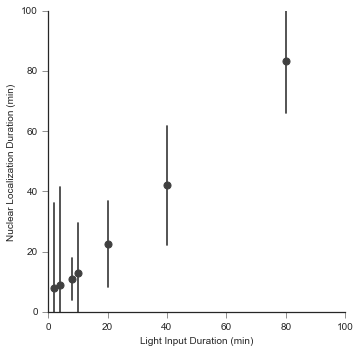

In [60]:
#plot duration of nuclear localization
sns.set_palette(sns.color_palette("Greys_r", 4))
lm_plot = sns.lmplot(x='Light Input', y='Localization', data=localization_df_sc, x_estimator = np.median, x_ci='sd', 
                     ci=None, fit_reg=False)
lm_plot.set(ylim=(0,100))
lm_plot.set(xlim=(0,100))
lm_plot.set(ylabel="Nuclear Localization Duration (min)", xlabel="Light Input Duration (min)")
figure = "Figure 1D_"
date = "20180321_27"
dest = figure + date + '_localization_lmPlot_singleCell_std'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

In [61]:
#read in nuclear intensity files
d0_nuc, d64_nuc, d128_nuc, d256_nuc, d512_nuc, d1024_nuc = [pd.read_csv(x, header=None) for x in 
                                                            glob.glob(dataRepo + '2018032*_d*CTSeed_nuc.csv')]
#cytoplasmic intensity files
d0_cyt, d64_cyt, d128_cyt, d256_cyt, d512_cyt, d1024_cyt = [pd.read_csv(x, header=None) for x in 
                                                            glob.glob(dataRepo + '2018032*_d*CTSeed_cyt.csv')]
#background intensity files
d0_bkg, d64_bkg, d128_bkg, d256_bkg, d512_bkg, d1024_bkg = [pd.read_csv(x, header=None) for x in 
                                                            glob.glob(dataRepo + '2018032*_d*CTSeed_bkg.csv')]

In [62]:
#adjust nuclear and cytoplasmic intensity by subtracting background brightness
d_nuc_list = [d0_nuc, d64_nuc, d128_nuc, d256_nuc, d512_nuc, d1024_nuc]
d_cyt_list = [d0_cyt, d64_cyt, d128_cyt, d256_cyt, d512_cyt, d1024_cyt]
d_bkg_list = [d0_bkg, d64_bkg, d128_bkg, d256_bkg, d512_bkg, d1024_bkg]
d0_nucAdj, d64_nucAdj, d128_nucAdj, d256_nucAdj, d512_nucAdj, d1024_nucAdj = [bkgAdj(d_nuc_list[i], d_bkg_list[i]) for i in 
                                                                  range(len(d_bkg_list))]
d0_cytAdj, d64_cytAdj, d128_cytAdj, d256_cytAdj, d512_cytAdj, d1024_cytAdj = [bkgAdj(d_cyt_list[i], d_bkg_list[i]) for i in 
                                                                  range(len(d_bkg_list))]

In [63]:
#remove untracked cells
d0_nucAdj_rm_UT, d0_cytAdj_rm_UT = rmUntrackedCells(d0_nucAdj, d0_cytAdj, 2)
d64_nucAdj_rm_UT, d64_cytAdj_rm_UT = rmUntrackedCells(d64_nucAdj, d64_cytAdj, 2)
d128_nucAdj_rm_UT, d128_cytAdj_rm_UT = rmUntrackedCells(d128_nucAdj, d128_cytAdj, 2)
d256_nucAdj_rm_UT, d256_cytAdj_rm_UT = rmUntrackedCells(d256_nucAdj, d256_cytAdj, 2)
d512_nucAdj_rm_UT, d512_cytAdj_rm_UT = rmUntrackedCells(d512_nucAdj, d512_cytAdj, 2)
d1024_nucAdj_rm_UT, d1024_cytAdj_rm_UT = rmUntrackedCells(d1024_nucAdj, d1024_cytAdj, 2)

In [64]:
#calculate nuclear enrichment
d0_nucCytoEnr_rm_UT, d0_normNucCytoEnr_rm_UT = nucEnrich(d0_nucAdj_rm_UT, d0_cytAdj_rm_UT)
d64_nucCytoEnr_rm_UT, d64_normNucCytoEnr_rm_UT = nucEnrich(d64_nucAdj_rm_UT, d64_cytAdj_rm_UT)
d128_nucCytoEnr_rm_UT, d128_normNucCytoEnr_rm_UT = nucEnrich(d128_nucAdj_rm_UT, d128_cytAdj_rm_UT)
d256_nucCytoEnr_rm_UT, d256_normNucCytoEnr_rm_UT = nucEnrich(d256_nucAdj_rm_UT, d256_cytAdj_rm_UT)
d512_nucCytoEnr_rm_UT, d512_normNucCytoEnr_rm_UT = nucEnrich(d512_nucAdj_rm_UT, d512_cytAdj_rm_UT)
d1024_nucCytoEnr_rm_UT, d1024_normNucCytoEnr_rm_UT = nucEnrich(d1024_nucAdj_rm_UT, d1024_cytAdj_rm_UT)

In [65]:
#remove cells which have negative values for enrichment
d0_normNucCytoEnr_rm2 = rmOutliers(d0_normNucCytoEnr_rm_UT, 0)
d64_normNucCytoEnr_rm2 = rmOutliers(d64_normNucCytoEnr_rm_UT, 0)
d128_normNucCytoEnr_rm2 = rmOutliers(d128_normNucCytoEnr_rm_UT, 0)
d256_normNucCytoEnr_rm2 = rmOutliers(d256_normNucCytoEnr_rm_UT, 0)
d512_normNucCytoEnr_rm2 = rmOutliers(d512_normNucCytoEnr_rm_UT, 0)
d1024_normNucCytoEnr_rm2 = rmOutliers(d1024_normNucCytoEnr_rm_UT, 0)

In [66]:
print "number of tracked cells for 512 input: " + str(d512_normNucCytoEnr_rm2.shape[1] )
print "number of tracked cells for 1024 input: " + str(d1024_normNucCytoEnr_rm2.shape[1] )


number of tracked cells for 512 input: 36
number of tracked cells for 1024 input: 36


As printed above, the 512 input and 1024 have the same number of tracked cells, despite the 512 set of images having 3-5x as many cells in the field of view. I think this shows that there was poor tracking in the 512 image (which is likely also due to the image being out of focus and cells being too dense), so in future analyses we will drop this input.

In [67]:
##make a long df with max localization for each cell in response to each amplitude. plot in a line graph with sd.
long_d0_maxNormNucCytoEnr_rm2 = pd.DataFrame(data=d0_normNucCytoEnr_rm2.max(axis=0), columns=['Max Localization'])
long_d64_maxNormNucCytoEnr_rm2 = pd.DataFrame(data=d64_normNucCytoEnr_rm2.max(axis=0), columns=['Max Localization'])
long_d128_maxNormNucCytoEnr_rm2 = pd.DataFrame(data=d128_normNucCytoEnr_rm2.max(axis=0), columns=['Max Localization'])
long_d256_maxNormNucCytoEnr_rm2 = pd.DataFrame(data=d256_normNucCytoEnr_rm2.max(axis=0), columns=['Max Localization'])
long_d1024_maxNormNucCytoEnr_rm2 = pd.DataFrame(data=d1024_normNucCytoEnr_rm2.max(axis=0), columns=['Max Localization'])

long_d0_maxNormNucCytoEnr_rm2["Light Input"] = [0]*len(long_d0_maxNormNucCytoEnr_rm2)
long_d64_maxNormNucCytoEnr_rm2["Light Input"] = [64]*len(long_d64_maxNormNucCytoEnr_rm2)
long_d128_maxNormNucCytoEnr_rm2["Light Input"] = [128]*len(long_d128_maxNormNucCytoEnr_rm2)
long_d256_maxNormNucCytoEnr_rm2["Light Input"] = [256]*len(long_d256_maxNormNucCytoEnr_rm2)
long_d1024_maxNormNucCytoEnr_rm2["Light Input"] = [1024]*len(long_d1024_maxNormNucCytoEnr_rm2)

long_allInputs_maxNormNucCytoEnr_rm2 = pd.concat([long_d0_maxNormNucCytoEnr_rm2, long_d64_maxNormNucCytoEnr_rm2, long_d128_maxNormNucCytoEnr_rm2,
                                             long_d256_maxNormNucCytoEnr_rm2, long_d1024_maxNormNucCytoEnr_rm2])

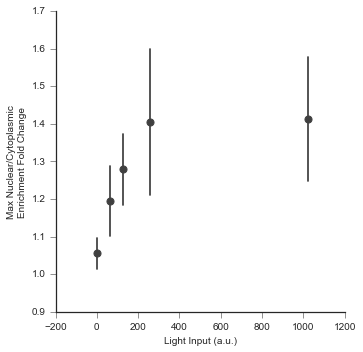

In [68]:
#plot max fold change
sns.lmplot(x="Light Input", y="Max Localization", data=long_allInputs_maxNormNucCytoEnr_rm2, 
           x_estimator=np.mean, fit_reg=False, x_ci="sd", ci=None)
plt.xlabel("Light Input (a.u.)")
plt.ylabel("Max Nuclear/Cytoplasmic\nEnrichment Fold Change")
figure = "Figure1D_"
date = "20180324"
dest = figure + date + '_maxLocalization_lmPlot'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

# Figure 1E

In [73]:
#read in nuclear intensity files
dose2mnuc_p1, dose3mnuc_p1, dose5mnuc_p1, dose7mnuc_p1, dose9mnuc_p1, dose0mnuc_p1 = [pd.read_csv(x, header=None) for 
                                                                    x in glob.glob(dataRepo+"2018041*_p1CTSeed_*_nuc.csv")]
dose2mnuc_p2, dose3mnuc_p2, dose5mnuc_p2, dose7mnuc_p2, dose0mnuc_p2, dose9mnuc_p2 = [pd.read_csv(x, header=None) for 
                                                                    x in glob.glob(dataRepo+"2018041*_p2CTSeed_*_nuc.csv")]
dose2mnuc_p1_0529, dose2mnuc_p2_0529 = [pd.read_csv(x, header=None) for x 
                                        in glob.glob(dataRepo+"20180601_p*CTSeed_1m2m_nuc.csv")]

#read in cytoplasmic intensity files
dose2mcyt_p1, dose3mcyt_p1, dose5mcyt_p1, dose7mcyt_p1, dose9mcyt_p1, dose0mcyt_p1 = [pd.read_csv(x, header=None) for 
                                                                    x in glob.glob(dataRepo+"2018041*_p1CTSeed_*_cyt.csv")]
dose2mcyt_p2, dose3mcyt_p2, dose5mcyt_p2, dose7mcyt_p2, dose0mcyt_p2, dose9mcyt_p2 = [pd.read_csv(x, header=None) for 
                                                                    x in glob.glob(dataRepo+"2018041*_p2CTSeed_*_cyt.csv")]
dose2mcyt_p1_0529, dose2mcyt_p2_0529 = [pd.read_csv(x, header=None) for x 
                                        in glob.glob(dataRepo+"20180601_p*CTSeed_1m2m_cyt.csv")]

#read in background intensity files
dose2mbkg_p1, dose3mbkg_p1, dose5mbkg_p1, dose7mbkg_p1, dose9mbkg_p1, dose0mbkg_p1 = [pd.read_csv(x, header=None) for 
                                                                    x in glob.glob(dataRepo+"2018041*_p1CTSeed_*_bkg.csv")]
dose2mbkg_p2, dose3mbkg_p2, dose5mbkg_p2, dose7mbkg_p2, dose0mbkg_p2, dose9mbkg_p2 = [pd.read_csv(x, header=None) for 
                                                                    x in glob.glob(dataRepo+"2018041*_p2CTSeed_*_bkg.csv")]
dose2mbkg_p1_0529, dose2mbkg_p2_0529 = [pd.read_csv(x, header=None) for x 
                                        in glob.glob(dataRepo+"20180601_p*CTSeed_1m2m_bkg.csv")]

In [74]:
#adjust nuclear and cytoplasmic intensity by background value
p1_nuc_list =[dose2mnuc_p1, dose3mnuc_p1, dose5mnuc_p1, dose7mnuc_p1, dose9mnuc_p1, dose0mnuc_p1]
p2_nuc_list = [dose2mnuc_p2, dose3mnuc_p2, dose5mnuc_p2, dose7mnuc_p2, dose9mnuc_p2, dose0mnuc_p2]
d0529_nuc_list = [dose2mnuc_p1_0529, dose2mnuc_p2_0529]

p1_cyt_list =[dose2mcyt_p1, dose3mcyt_p1, dose5mcyt_p1, dose7mcyt_p1, dose9mcyt_p1, dose0mcyt_p1]
p2_cyt_list = [dose2mcyt_p2, dose3mcyt_p2, dose5mcyt_p2, dose7mcyt_p2, dose9mcyt_p2, dose0mcyt_p2]
d0529_cyt_list = [dose2mcyt_p1_0529, dose2mcyt_p2_0529]

p1_bkg_list =[dose2mbkg_p1, dose3mbkg_p1, dose5mbkg_p1, dose7mbkg_p1, dose9mbkg_p1, dose0mbkg_p1]
p2_bkg_list = [dose2mbkg_p2, dose3mbkg_p2, dose5mbkg_p2, dose7mbkg_p2, dose9mbkg_p2, dose0mbkg_p2]
d0529_bkg_list = [dose2mbkg_p1_0529, dose2mbkg_p2_0529]

dose2mnucAdj_p1, dose3mnucAdj_p1, dose5mnucAdj_p1, dose7mnucAdj_p1, dose9mnucAdj_p1, dose0mnucAdj_p1 = [bkgAdj(p1_nuc_list[i],
                                                                                p1_bkg_list[i]) for i in range(len(p1_bkg_list))]
dose2mcytAdj_p1, dose3mcytAdj_p1, dose5mcytAdj_p1, dose7mcytAdj_p1, dose9mcytAdj_p1, dose0mcytAdj_p1 = [bkgAdj(p1_cyt_list[i],
                                                                                p1_bkg_list[i]) for i in range(len(p1_bkg_list))]
dose2mnucAdj_p1_0529, dose2mnucAdj_p2_0529 = [bkgAdj(d0529_nuc_list[i], d0529_bkg_list[i]) for i in range(len(d0529_bkg_list))]


dose2mnucAdj_p2, dose3mnucAdj_p2, dose5mnucAdj_p2, dose7mnucAdj_p2, dose9mnucAdj_p2, dose0mnucAdj_p2 = [bkgAdj(p2_nuc_list[i],
                                                                                p2_bkg_list[i]) for i in range(len(p2_bkg_list))]
dose2mcytAdj_p2, dose3mcytAdj_p2, dose5mcytAdj_p2, dose7mcytAdj_p2, dose9mcytAdj_p2, dose0mcytAdj_p2 = [bkgAdj(p2_cyt_list[i],
                                                                                p2_bkg_list[i]) for i in range(len(p2_bkg_list))]
dose2mcytAdj_p1_0529, dose2mcytAdj_p2_0529 = [bkgAdj(d0529_cyt_list[i], d0529_bkg_list[i]) for i in range(len(d0529_bkg_list))]


In [75]:
dose2mnucAdj_p1_rm_UT, dose2mcytAdj_p1_rm_UT = rmUntrackedCells(dose2mnucAdj_p1, dose2mcytAdj_p1, 3)
dose3mnucAdj_p1_rm_UT, dose3mcytAdj_p1_rm_UT = rmUntrackedCells(dose3mnucAdj_p1, dose3mcytAdj_p1, 3)
dose5mnucAdj_p1_rm_UT, dose5mcytAdj_p1_rm_UT = rmUntrackedCells(dose5mnucAdj_p1, dose5mcytAdj_p1, 3)
dose7mnucAdj_p1_rm_UT, dose7mcytAdj_p1_rm_UT = rmUntrackedCells(dose7mnucAdj_p1, dose7mcytAdj_p1, 3)
dose9mnucAdj_p1_rm_UT, dose9mcytAdj_p1_rm_UT = rmUntrackedCells(dose9mnucAdj_p1, dose9mcytAdj_p1, 3)

dose2mnucAdj_p2_rm_UT, dose2mcytAdj_p2_rm_UT = rmUntrackedCells(dose2mnucAdj_p2, dose2mcytAdj_p2, 3)
dose3mnucAdj_p2_rm_UT, dose3mcytAdj_p2_rm_UT = rmUntrackedCells(dose3mnucAdj_p2, dose3mcytAdj_p2, 3)
dose5mnucAdj_p2_rm_UT, dose5mcytAdj_p2_rm_UT = rmUntrackedCells(dose5mnucAdj_p2, dose5mcytAdj_p2, 3)
dose7mnucAdj_p2_rm_UT, dose7mcytAdj_p2_rm_UT = rmUntrackedCells(dose7mnucAdj_p2, dose7mcytAdj_p2, 3)
dose9mnucAdj_p2_rm_UT, dose9mcytAdj_p2_rm_UT = rmUntrackedCells(dose9mnucAdj_p2, dose9mcytAdj_p2, 3)

dose2mnucAdj_p1_rm_UT_0529, dose2mcytAdj_p1_rm_UT_0529 = rmUntrackedCells(dose2mnucAdj_p1_0529, dose2mcytAdj_p1_0529, 3)
dose2mnucAdj_p2_rm_UT_0529, dose2mcytAdj_p2_rm_UT_0529 = rmUntrackedCells(dose2mnucAdj_p2_0529, dose2mcytAdj_p2_0529, 3)

In [76]:
#calculate nuclear enrichment
dose2mnucCytoEnr_p1_rm_UT, dose2mnormNucCytoEnr_p1_rm_UT = nucEnrich(dose2mnucAdj_p1_rm_UT, dose2mcytAdj_p1_rm_UT)
dose3mnucCytoEnr_p1_rm_UT, dose3mnormNucCytoEnr_p1_rm_UT = nucEnrich(dose3mnucAdj_p1_rm_UT, dose3mcytAdj_p1_rm_UT)
dose5mnucCytoEnr_p1_rm_UT, dose5mnormNucCytoEnr_p1_rm_UT = nucEnrich(dose5mnucAdj_p1_rm_UT, dose5mcytAdj_p1_rm_UT)
dose7mnucCytoEnr_p1_rm_UT, dose7mnormNucCytoEnr_p1_rm_UT = nucEnrich(dose7mnucAdj_p1_rm_UT, dose7mcytAdj_p1_rm_UT)
dose9mnucCytoEnr_p1_rm_UT, dose9mnormNucCytoEnr_p1_rm_UT = nucEnrich(dose9mnucAdj_p1_rm_UT, dose9mcytAdj_p1_rm_UT)

dose2mnucCytoEnr_p2_rm_UT, dose2mnormNucCytoEnr_p2_rm_UT = nucEnrich(dose2mnucAdj_p2_rm_UT, dose2mcytAdj_p2_rm_UT)
dose3mnucCytoEnr_p2_rm_UT, dose3mnormNucCytoEnr_p2_rm_UT = nucEnrich(dose3mnucAdj_p2_rm_UT, dose3mcytAdj_p2_rm_UT)
dose5mnucCytoEnr_p2_rm_UT, dose5mnormNucCytoEnr_p2_rm_UT = nucEnrich(dose5mnucAdj_p2_rm_UT, dose5mcytAdj_p2_rm_UT)
dose7mnucCytoEnr_p2_rm_UT, dose7mnormNucCytoEnr_p2_rm_UT = nucEnrich(dose7mnucAdj_p2_rm_UT, dose7mcytAdj_p2_rm_UT)
dose9mnucCytoEnr_p2_rm_UT, dose9mnormNucCytoEnr_p2_rm_UT = nucEnrich(dose9mnucAdj_p2_rm_UT, dose9mcytAdj_p2_rm_UT)

dose2mnucCytoEnr_p1_rm_UT_0529, dose2mnormNucCytoEnr_p1_rm_UT_0529 = nucEnrich(dose2mnucAdj_p1_rm_UT_0529, 
                                                                               dose2mcytAdj_p1_rm_UT_0529)
dose2mnucCytoEnr_p2_rm_UT_0529, dose2mnormNucCytoEnr_p2_rm_UT_0529 = nucEnrich(dose2mnucAdj_p2_rm_UT_0529, 
                                                                               dose2mcytAdj_p2_rm_UT_0529)

In [77]:
#remove cells with negative values
[dose2mnormNucCytoEnr_p1_rm2, dose3mnormNucCytoEnr_p1_rm2, dose5mnormNucCytoEnr_p1_rm2, 
 dose7mnormNucCytoEnr_p1_rm2, dose9mnormNucCytoEnr_p1_rm2] = [rmOutliers(x, 0) for x in [dose2mnormNucCytoEnr_p1_rm_UT, 
                                                            dose3mnormNucCytoEnr_p1_rm_UT, dose5mnormNucCytoEnr_p1_rm_UT,
                                                                dose7mnormNucCytoEnr_p1_rm_UT, dose9mnormNucCytoEnr_p1_rm_UT]]
[dose2mnormNucCytoEnr_p2_rm2, dose3mnormNucCytoEnr_p2_rm2, dose5mnormNucCytoEnr_p2_rm2, 
 dose7mnormNucCytoEnr_p2_rm2, dose9mnormNucCytoEnr_p2_rm2] = [rmOutliers(x, 0) for x in [dose2mnormNucCytoEnr_p2_rm_UT, 
                                                            dose3mnormNucCytoEnr_p2_rm_UT, dose5mnormNucCytoEnr_p2_rm_UT,
                                                                dose7mnormNucCytoEnr_p2_rm_UT, dose9mnormNucCytoEnr_p2_rm_UT]]
dose2mnormNucCytoEnr_p1_rm2_0529, dose2mnormNucCytoEnr_p2_rm2_0529 = [rmOutliers(x, 0) 
                                                                      for x in [dose2mnormNucCytoEnr_p1_rm_UT_0529,
                                                                    dose2mnormNucCytoEnr_p2_rm_UT_0529]]

In [78]:
#change dataframes from wide to long
[longdose2mnormNucCytoEnr_p1_rm2, longdose3mnormNucCytoEnr_p1_rm2, longdose5mnormNucCytoEnr_p1_rm2, 
 longdose7mnormNucCytoEnr_p1_rm2, longdose9mnormNucCytoEnr_p1_rm2] = [pd.melt(x) for x in [dose2mnormNucCytoEnr_p1_rm2, 
                                                                    dose3mnormNucCytoEnr_p1_rm2, dose5mnormNucCytoEnr_p1_rm2, 
                                                                    dose7mnormNucCytoEnr_p1_rm2, dose9mnormNucCytoEnr_p1_rm2]]
[longdose2mnormNucCytoEnr_p2_rm2, longdose3mnormNucCytoEnr_p2_rm2, longdose5mnormNucCytoEnr_p2_rm2, 
 longdose7mnormNucCytoEnr_p2_rm2, longdose9mnormNucCytoEnr_p2_rm2] = [pd.melt(x) for x in [dose2mnormNucCytoEnr_p2_rm2, 
                                                                    dose3mnormNucCytoEnr_p2_rm2, dose5mnormNucCytoEnr_p2_rm2, 
                                                                    dose7mnormNucCytoEnr_p2_rm2, dose9mnormNucCytoEnr_p2_rm2]]
longdose2mnormNucCytoEnr_p1_rm2_0529, longdose2mnormNucCytoEnr_p2_rm2_0529 = [pd.melt(x) for x in 
                                                            [dose2mnormNucCytoEnr_p1_rm2_0529, dose2mnormNucCytoEnr_p2_rm2_0529]]

In [79]:
#calculate the time of each iput (starting with t=0) given that images are taken 30s apart
longdose2mnormNucCytoEnr_p1_rm2["timepoint"] = np.arange(0,dose2mnormNucCytoEnr_p1_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose2mnormNucCytoEnr_p1_rm2.shape[1]
longdose3mnormNucCytoEnr_p1_rm2["timepoint"] = np.arange(0,dose3mnormNucCytoEnr_p1_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose3mnormNucCytoEnr_p1_rm2.shape[1]
longdose5mnormNucCytoEnr_p1_rm2["timepoint"] = np.arange(0,dose5mnormNucCytoEnr_p1_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose5mnormNucCytoEnr_p1_rm2.shape[1]
longdose7mnormNucCytoEnr_p1_rm2["timepoint"] = np.arange(0,dose7mnormNucCytoEnr_p1_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose7mnormNucCytoEnr_p1_rm2.shape[1]
longdose9mnormNucCytoEnr_p1_rm2["timepoint"] = np.arange(0,dose9mnormNucCytoEnr_p1_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose9mnormNucCytoEnr_p1_rm2.shape[1]

longdose2mnormNucCytoEnr_p2_rm2["timepoint"] = np.arange(0,dose2mnormNucCytoEnr_p2_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose2mnormNucCytoEnr_p2_rm2.shape[1]
longdose3mnormNucCytoEnr_p2_rm2["timepoint"] = np.arange(0,dose3mnormNucCytoEnr_p2_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose3mnormNucCytoEnr_p2_rm2.shape[1]
longdose5mnormNucCytoEnr_p2_rm2["timepoint"] = np.arange(0,dose5mnormNucCytoEnr_p2_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose5mnormNucCytoEnr_p2_rm2.shape[1]
longdose7mnormNucCytoEnr_p2_rm2["timepoint"] = np.arange(0,dose7mnormNucCytoEnr_p2_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose7mnormNucCytoEnr_p2_rm2.shape[1]
longdose9mnormNucCytoEnr_p2_rm2["timepoint"] = np.arange(0,dose9mnormNucCytoEnr_p2_rm2.shape[0]/2.0, 
                                                         step=0.5).tolist()*dose9mnormNucCytoEnr_p2_rm2.shape[1]

longdose2mnormNucCytoEnr_p1_rm2_0529["timepoint"] = np.arange(0,dose2mnormNucCytoEnr_p1_rm2_0529.shape[0]/2.0, 
                                                              step=0.5).tolist()*dose2mnormNucCytoEnr_p1_rm2_0529.shape[1]
longdose2mnormNucCytoEnr_p2_rm2_0529["timepoint"] = np.arange(0,dose2mnormNucCytoEnr_p2_rm2_0529.shape[0]/2.0, 
                                                              step=0.5).tolist()*dose2mnormNucCytoEnr_p2_rm2_0529.shape[1]

In [80]:
#pandas will error if cell traces have the same variable number -- for the second field of view, 
#increment all variable numbers by 100
for long_df in [longdose2mnormNucCytoEnr_p2_rm2, longdose3mnormNucCytoEnr_p2_rm2, longdose5mnormNucCytoEnr_p2_rm2, 
                longdose7mnormNucCytoEnr_p2_rm2, longdose9mnormNucCytoEnr_p2_rm2, longdose2mnormNucCytoEnr_p2_rm2_0529]:
    long_df['variable'] += 100


In [81]:
#concat the fields of view
longdose2mnormNucCytoEnr_rm2 = pd.concat([longdose2mnormNucCytoEnr_p1_rm2, longdose2mnormNucCytoEnr_p2_rm2], ignore_index=True)
longdose3mnormNucCytoEnr_rm2 = pd.concat([longdose3mnormNucCytoEnr_p1_rm2, longdose3mnormNucCytoEnr_p2_rm2], ignore_index=True)
longdose5mnormNucCytoEnr_rm2 = pd.concat([longdose5mnormNucCytoEnr_p1_rm2, longdose5mnormNucCytoEnr_p2_rm2], ignore_index=True)
longdose7mnormNucCytoEnr_rm2 = pd.concat([longdose7mnormNucCytoEnr_p1_rm2, longdose7mnormNucCytoEnr_p2_rm2], ignore_index=True)
longdose9mnormNucCytoEnr_rm2 = pd.concat([longdose9mnormNucCytoEnr_p1_rm2, longdose9mnormNucCytoEnr_p2_rm2], ignore_index=True)

longdose2mnormNucCytoEnr_rm2_0529 = pd.concat([longdose2mnormNucCytoEnr_p1_rm2_0529, longdose2mnormNucCytoEnr_p2_rm2_0529], 
                                              ignore_index=True)

C:\Users\Lindsey\Miniconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


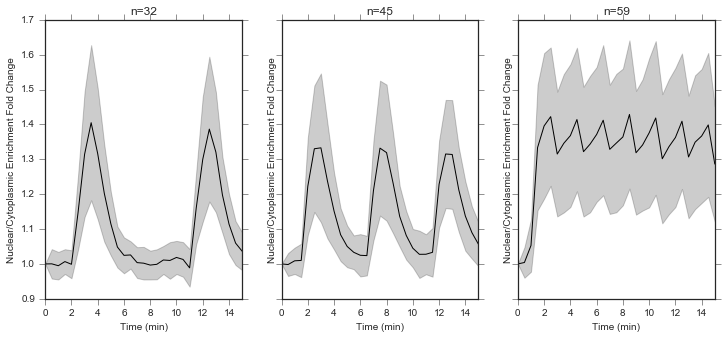

In [58]:
#cells with 2m period are tracked for a longer time on 05/29, so we will use those traces
fig, ax = plt.subplots(1, 3, sharey = True, sharex=True, figsize=(12, 5))
sns.tsplot(data=longdose9mnormNucCytoEnr_rm2, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci="sd", color="black", estimator=np.nanmean, ax = ax[0])
sns.tsplot(data=longdose5mnormNucCytoEnr_rm2, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci="sd", color="black", estimator=np.nanmean, ax = ax[1])
sns.tsplot(data=longdose2mnormNucCytoEnr_rm2_0529, time="timepoint", unit="variable", value="value",err_style='ci_band', 
           ci="sd", color="black", estimator=np.nanmean, ax = ax[2])
ax[0].set_title("n=" + str(dose9mnormNucCytoEnr_p1_rm2.shape[1]+dose9mnormNucCytoEnr_p2_rm2.shape[1]))
ax[1].set_title("n=" + str(dose5mnormNucCytoEnr_p1_rm2.shape[1]+dose5mnormNucCytoEnr_p2_rm2.shape[1]))
ax[2].set_title("n=" + str(dose2mnormNucCytoEnr_p1_rm2_0529.shape[1]+dose2mnormNucCytoEnr_p2_rm2_0529.shape[1]))
for i in range(0,3):
    ax[i].set_ylabel("Nuclear/Cytoplasmic Enrichment Fold Change")
    ax[i].set_xlabel("Time (min)")
plt.xlim(0,15)
figure = "Figure 1D_"
date = "20180414_0529"
dest = figure + date + '_yLO213_periodicDoseResp_15m'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

In [82]:
def getPeakNucEnr(cell_trace_means_series):
    return [cell_trace_means_series.max(), cell_trace_means_series.idxmax()]
def getMinNucEnr(cell_trace_means_series, maxEnrInd):
    return [cell_trace_means_series[maxEnrInd:].min(), cell_trace_means_series[maxEnrInd:].idxmin()]
def getLocalMinNucEnr(cell_trace_means_series, maxEnrInd):
    #maxEnrInd = int(cell_trace_means_peaks_series['peakEnrInd'])
    try:
        localMinimum = argrelextrema(np.array(cell_trace_means_series[maxEnrInd:]), np.less)[0][0] + maxEnrInd
    except IndexError:
        localMinimum = np.nan
        return [np.nan, localMinimum]
    return [cell_trace_means_series[localMinimum], localMinimum]
def getLocalMaxima(cell_trace_means_series):
    return argrelextrema(np.array(cell_trace_means_series), np.greater)[0]
def getLocalMinima(cell_trace_means_series):
    return argrelextrema(np.array(cell_trace_means_series), np.less)[0]
def getAmpRange(cell_trace_means_series):
    max_nuc_enr, max_nuc_enr_ind = getPeakNucEnr(cell_trace_means_series)
    min_nuc_enr, min_nuc_enr_ind = getMinNucEnr(cell_trace_means_series, max_nuc_enr_ind)
    return (max_nuc_enr-min_nuc_enr)
def getAmpRangeSC(cell_trace_means_series):
    max_nuc_enr, max_nuc_enr_ind = getPeakNucEnr(cell_trace_means_series)
    min_nuc_enr, min_nuc_enr_ind = getLocalMinNucEnr(cell_trace_means_series, max_nuc_enr_ind)
    return (max_nuc_enr-min_nuc_enr)
def getPeakTroughSummary(cell_trace_means_series, norm =1, normQuantity = .05, median_or_max=0):
    #if median value is desired, make median_or_max = 1
    #norm, like smoothing, removes peak-trough differences which are small (these are primarily due to noise)
    #normQuantity is what defines "small" -- .05 is selected as the default because the max average amplitude range is ~.5,
    #and many of the noise points seemed to be in the ballpark of -.03-.05
    cell_trace_smooth = cell_trace_means_series.rolling(2, center=True).mean()
    #cell_trace_smooth = cell_trace_means_series.copy()
    localMaxArray = getLocalMaxima(cell_trace_smooth)
    localMinArray = getLocalMinima(cell_trace_smooth)
    if localMaxArray.shape[0] < localMinArray.shape[0]:
        commonArrayLen = localMaxArray.shape[0]
    else:
        commonArrayLen = localMinArray.shape[0]
    adjLocalMaxArray = localMaxArray[0:commonArrayLen]
    adjLocalMinArray = localMinArray[0:commonArrayLen]
    differenceArray = (cell_trace_smooth[adjLocalMaxArray].reset_index(drop=True)-
                cell_trace_smooth[adjLocalMinArray].reset_index(drop=True))
    if norm:
        differenceArrayNorm = differenceArray[differenceArray>normQuantity]
    else:
        differenceArrayNorm = differenceArray.copy()
    if median_or_max:
        return differenceArrayNorm.median()
    else:
        return differenceArrayNorm.max()
def getPeakTroughRatio(cell_trace_means_series, norm =1, normQuantity = .05, median_or_max=0):
    #if median value is desired, make median_or_max = 1
    #norm, like smoothing, removes peak-trough differences which are small (these are primarily due to noise)
    #normQuantity is what defines "small" -- .05 is selected as the default because the max average amplitude range is ~.5,
    #and many of the noise points seemed to be in the ballpark of -.03-.05
    cell_trace_smooth = cell_trace_means_series.rolling(2, center=True).mean()
    #cell_trace_smooth = cell_trace_means_series.copy()
    localMaxArray = getLocalMaxima(cell_trace_smooth)
    localMinArray = getLocalMinima(cell_trace_smooth)
    if localMaxArray.shape[0] < localMinArray.shape[0]:
        commonArrayLen = localMaxArray.shape[0]
    else:
        commonArrayLen = localMinArray.shape[0]
    adjLocalMaxArray = localMaxArray[0:commonArrayLen]
    adjLocalMinArray = localMinArray[0:commonArrayLen]
    ratioArray = (cell_trace_smooth[adjLocalMaxArray].reset_index(drop=True)/cell_trace_smooth[adjLocalMinArray].reset_index(drop=True))
    if norm:
        ratioArrayNorm = ratioArray[ratioArray>normQuantity]
    else:
        ratioArrayNorm = ratioArray.copy()
    if median_or_max:
        return ratioArrayNorm.median()
    else:
        return ratioArrayNorm.max()


In [83]:
#concatenate the fields of view -- this time in wide format
dose2mnormNucCytoEnr_rm2_full = pd.concat([dose2mnormNucCytoEnr_p1_rm2_0529, dose2mnormNucCytoEnr_p2_rm2_0529], axis=1, ignore_index=True)
dose3mnormNucCytoEnr_rm2_full = pd.concat([dose3mnormNucCytoEnr_p1_rm2, dose3mnormNucCytoEnr_p2_rm2], axis=1, ignore_index=True)
dose5mnormNucCytoEnr_rm2_full = pd.concat([dose5mnormNucCytoEnr_p1_rm2, dose5mnormNucCytoEnr_p2_rm2], axis=1, ignore_index=True)
dose7mnormNucCytoEnr_rm2_full = pd.concat([dose7mnormNucCytoEnr_p1_rm2, dose7mnormNucCytoEnr_p2_rm2], axis=1, ignore_index=True)
dose9mnormNucCytoEnr_rm2_full = pd.concat([dose9mnormNucCytoEnr_p1_rm2, dose9mnormNucCytoEnr_p2_rm2], axis=1, ignore_index=True)

In [61]:
#add information about the frequency and period of light input to the dataframes
#period is given as part of the variable name/filename -- i.e. dose 2m means 2 minute period, or .5 frequency
freq_inputs_sc = ([.5]*dose2mnormNucCytoEnr_rm2_full.shape[1] + [(1/3.0)]*dose3mnormNucCytoEnr_rm2_full.shape[1] + 
[.2]*dose5mnormNucCytoEnr_rm2_full.shape[1] + [1/7.0]*dose7mnormNucCytoEnr_rm2_full.shape[1] + [(1/9.0)]*dose9mnormNucCytoEnr_rm2_full.shape[1])

period_inputs_sc = ([2]*dose2mnormNucCytoEnr_rm2_full.shape[1] + [3]*dose3mnormNucCytoEnr_rm2_full.shape[1] + 
[5]*dose5mnormNucCytoEnr_rm2_full.shape[1] + [7]*dose7mnormNucCytoEnr_rm2_full.shape[1] + [9]*dose9mnormNucCytoEnr_rm2_full.shape[1])

amp_range_sc = pd.concat([dose2mnormNucCytoEnr_rm2_full.apply(getPeakTroughSummary, axis=0, args=(1,.05, 1)), 
                          dose3mnormNucCytoEnr_rm2_full.apply(getPeakTroughSummary, axis=0, args=(1,.05, 1)), 
             dose5mnormNucCytoEnr_rm2_full.apply(getPeakTroughSummary, axis=0, args=(1,.05, 1)), 
                          dose7mnormNucCytoEnr_rm2_full.apply(getPeakTroughSummary, axis=0, args=(1,.05, 1)), 
             dose9mnormNucCytoEnr_rm2_full.apply(getPeakTroughSummary, axis=0, args=(1, .05, 1))])

freq_amp_sc_df = pd.DataFrame(data={'Frequency': freq_inputs_sc, 'Amplitude Range': amp_range_sc})
freq_amp_period_sc_df = pd.DataFrame(data={'Frequency': freq_inputs_sc, 'Amplitude Range': amp_range_sc,  'Period': period_inputs_sc})
amp_range_norm = amp_range_sc/(np.double(freq_amp_sc_df.groupby('Frequency').median().max()))
freq_amp_period_sc_df_norm = pd.DataFrame(data={'Frequency': freq_inputs_sc, 'Amplitude Range': amp_range_norm, 'Period': period_inputs_sc})

C:\Users\Lindsey\Miniconda\lib\site-packages\scipy\signal\_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\Lindsey\Miniconda\lib\site-packages\scipy\signal\_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\Lindsey\Miniconda\lib\site-packages\scipy\signal\_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Lindsey\Miniconda\lib\site-packages\scipy\signal\_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


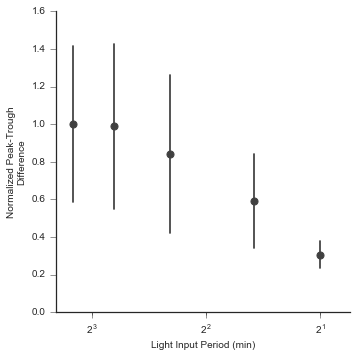

In [62]:
lm_plot = sns.lmplot(x='Period', y='Amplitude Range', data=freq_amp_period_sc_df_norm, x_estimator=np.nanmedian, x_ci='sd', fit_reg=False)
plt.ylim(0, 1.6)
plt.xlim(10,(1/0.6))
plt.xscale("log", basex=2)
plt.ylabel("Normalized Peak-Trough\nDifference")
plt.xlabel("Light Input Period (min)")
figure = "Figure 1D_"
date = "20180414_0529"
dest = figure + date + '_mScarlet_PeriodVsAmp_med_stdDev'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)

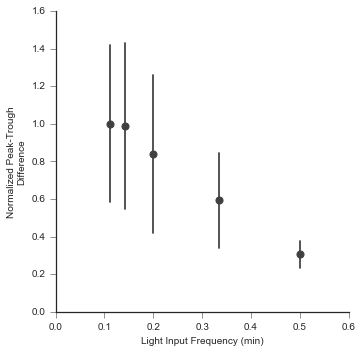

In [64]:
lm_plot = sns.lmplot(x='Frequency', y='Amplitude Range', data=freq_amp_period_sc_df_norm, x_estimator=np.nanmedian, x_ci='sd', fit_reg=False)
plt.ylim(0, 1.6)
plt.ylabel("Normalized Peak-Trough\nDifference")
plt.xlabel("Light Input Frequency (min)")
figure = "Figure 1D_"
date = "20180414_0529"
dest = figure + date + '_mScarlet_FreqVsAmp_med_stdDev'
#plt.savefig(dest + '.svg',dpi=300)
#plt.savefig(dest + '.png',dpi=300)